This code is meant to take the outputs of the KPZ solver and run Principal Component Analysis. The principal component can be used to extract physics parameters for different growth rates or surfaces.

In [18]:
import sys
from pathlib import Path

repo_root = Path.cwd().parent  # adjust" if notebook lives in notebooks/
sys.path.append(str(repo_root / "src"))

import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
import sklearn.decomposition as skld
from KPZ_solver import KPZSolver
from KPZ_visualizer import sample_plane, plot_2d_heatmap, animate_2d_heatmap
import umap
import sklearn.cluster
from IPython.display import display, Video

We first define some helper functions to assist with data preprocessing and postprocessing

In [ ]:
def flatten_arr(ts):
    '''Using numpy to reshape the time series data into a 2D array for PCA analysis'''
    ts_arr = np.array(ts)
    return ts_arr.reshape(ts_arr.shape[0], -1)

def flatten_for_indiv_PCA(ts):
    '''Returns data reshaped along last height dimension for individual PCA analysis'''
    return [flatten_arr(data) for data in ts]

def reshape_components(components, original_shape):
    '''Takes a list of components and returns to the original shape. Helpful after PCA on individual time series arrays.'''
    return [x.reshape(original_shape) for x in components]

(500, 160000)
(20, 8000)


In [24]:
def apply_umap(data, n_neighbors=5, min_dist=0.3, n_components=2, metric='euclidean'):
    '''A function to apply UMAP to the dataset in question'''
    reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components, metric=metric)
    return reducer.fit_transform(data)

def apply_PCA(data):
    '''Function to apply PCA to the dataset in question and extract important output arrays'''
    pca = skld.PCA(svd_solver='full')
    scores = pca.fit_transform(data)
    comps = pca.components_.copy()
    eigs = pca.explained_variance_.copy()
    return scores, comps, eigs

def perform_PCA_on_list(list_of_2d_arrays, svd_solver='full'):
    """
    Performing PCA individually in a list of 2D arrays
    Each entry of `list_of_2d_arrays` must be a 2D array with shape (n_samples, n_features).
    Returns three lists (components, explained_variance, scores) where:
      - components[i].shape == (n_components, n_features)
      - explained_variance[i].shape == (n_components,)
      - scores[i].shape == (n_samples, n_components)
    """
    out_components = []
    out_eigenvals = []
    out_scores = []

    for arr in list_of_2d_arrays:
        arr = np.asarray(arr)
        if arr.ndim != 2:
            raise ValueError(f"Expected 2D array (n_samples, n_features), got shape {arr.shape}")
        pca = skld.PCA(svd_solver=svd_solver)
        scores, comps, eigs = apply_PCA(arr)           # (n_samples, n_components)
        out_components.append(comps)
        out_eigenvals.append(eigs)
        out_scores.append(scores)

    return out_components, out_eigenvals, out_scores

In order to test the PCA software, we use a random multivariate Gaussian field and generate 500 'fake' timesteps to test that the PCA outputs make sense.

In [45]:
def multivariate_Gaussian_field(mean, std, rng, shape):
    flat_field = rng.normal(loc=mean, scale=std, size=np.prod(shape))
    return flat_field.reshape(shape)

rng = np.random.default_rng()

time_series = []
t = 500
for x in range(t):
    time_series.append(multivariate_Gaussian_field(mean=0.0,std=1.0, rng=rng, shape=(20,20,20,20)))

print(time_series[0].shape)

time_series_arr_flattened = flatten_arr(time_series)
timeser_arr_flat_sort = flatten_for_indiv_PCA(time_series)

print(time_series_arr_flattened.shape)
print(timeser_arr_flat_sort[0].shape)

eigens, eigvals, transformed = perform_PCA_on_list(timeser_arr_flat_sort)

print(len(eigens))

(20, 20, 20, 20)
(500, 160000)
(20, 8000)
500


Text(0, 0.5, 'Highest PCA eigenvalue')

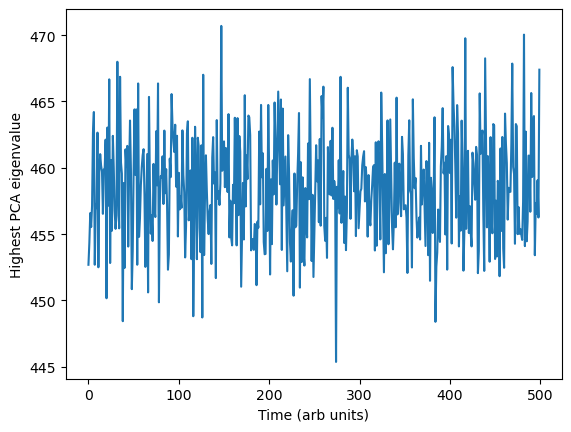

In [35]:
fig, axs = plt.subplots()
axs.plot([eigval[0] for eigval in eigvals])
axs.set_xlabel("Time (arb units)")
axs.set_ylabel("Highest PCA eigenvalue")

Text(0, 0.5, 'w')

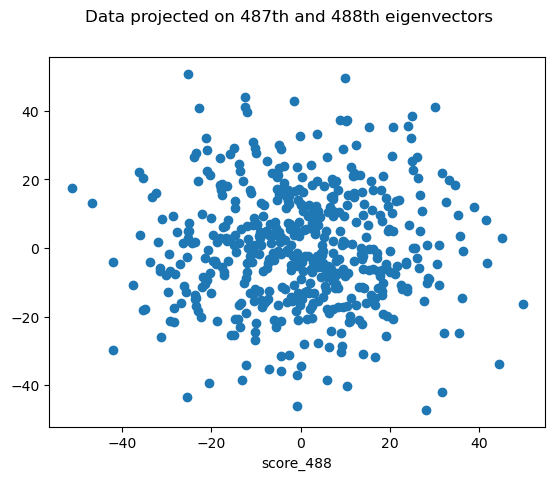

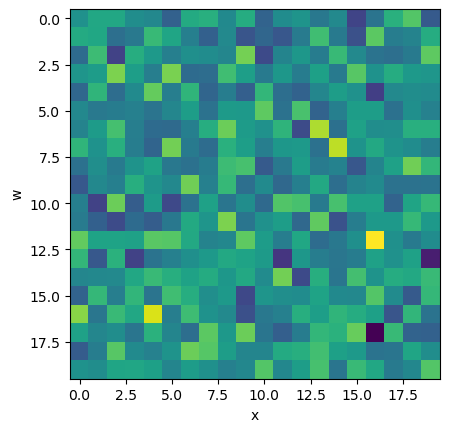

In [ ]:
scores, comps, eigs = apply_PCA(time_series_arr_flattened)

#Plotting scores to see that the data is normally distributed
fig2, axs2 = plt.subplots()
axs2.scatter(scores[:,488],scores[:,489])
axs2.set_xlabel("score_487")
axs2.set_xlabel("score_488")
fig2.suptitle("Data projected on 487th and 488th eigenvectors")

#Reshaping components so they are in the same space as they were created
comp1 = reshape_components(comps,(20,20,20,20))

#Looking at the projection of the largest component in the X-W plane (x,y,z,w)
proj = np.sum(comp1[0],axis=(0,3))

fig3, axs3 = plt.subplots()
obj = axs3.imshow(proj)
fig3.colorbar(obj)
axs3.set_xlabel("x")
axs3.set_ylabel("w")

We ultimately want to use this to try to find the most 'natural' way of interpreting the series of snapshots from the simulation. So we run the KPZ equation in 3D and use the sampling, plotting functions to visualize the solutions. This example was taken from the KPZ_test_and_visualization notebook.

In [38]:
# -----------------------------
# Example: KPZ in 3D, then use the sampling + plotting functions
# -----------------------------

# --- KPZ setup ---
L = (10.0, 10.0, 10.0)     # 3D domain
N = (40, 40, 40)           # resolution (keep modest so it runs fast)
dt = 5e-4
T = 2.0                    # final time
nu = 1.0
lam = 2.0
noise_strength = 0.50
d = 3

# Initial condition: small random perturbation around flat
def init_3d(x, y, z):
    return 0.1 * np.sin(2*np.pi*x/L[0]) + 0.05 * np.cos(2*np.pi*y/L[1]) \
           + 0.02 * np.random.default_rng(0).standard_normal(x.shape)

solver = KPZSolver(
    L=L,
    N=N,
    dt=dt,
    d=d,
    nu=nu,
    lam=lam,
    noise_strength=noise_strength,
    initial_condition=init_3d,
)

# Run and collect snapshots for possible animations
store_interval = 50
snapshots = solver.run(T=T, store_interval=store_interval)
coords = solver.coords

print(len(snapshots))

80


Here we do two things: run a PCA analysis on each snapshot in time and plot the resulting distribution.

(40, 40, 40)
(40, 40)
(40, 40, 40)


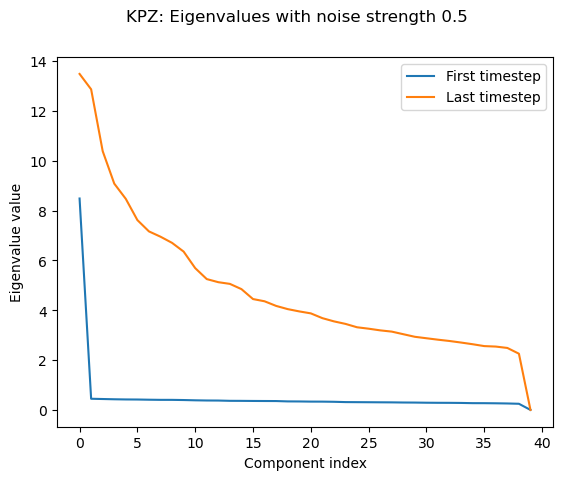

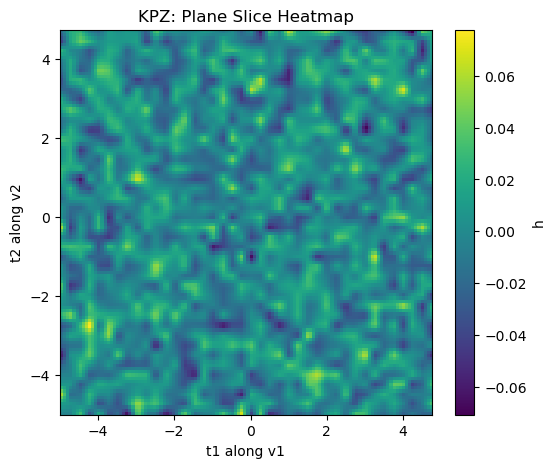

Text(0.5, 0.98, 'KPZ: Eigenvalues evolution over time')

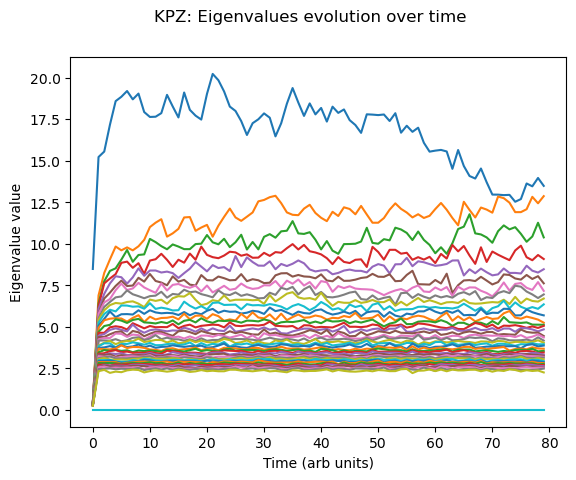

In [70]:
from IPython.display import HTML

print(snapshots[0].shape)

sreshaped = flatten_arr(snapshots)

reshaped_series = flatten_for_indiv_PCA(snapshots)

out_eigenv, out_eigenval, out_trans = perform_PCA_on_list(reshaped_series)

print(out_trans[0].shape)

out_eigenval = np.array(out_eigenval)


fig1, axs1 = plt.subplots()
axs1.plot(out_eigenval[0],label="First timestep")
axs1.plot(out_eigenval[-1],label="Last timestep")
axs1.set_xlabel("Component index")
axs1.set_ylabel("Eigenvalue value")
fig1.suptitle(f"KPZ: Eigenvalues with noise strength {noise_strength}")
axs1.legend()

reshaped_eigenvec = reshape_components(out_eigenv, N)
print(reshaped_eigenvec[0].shape)

x0_plane = [L[0]/2, L[1]/2, L[2]/2]  # center again
v1 = [0.0, 0.0, 1.0]                 # along x
v2 = [0.0, 1.0, 0.0]                 # along y

t_range = 10.0   # parametric range along v1, v2
t1_vals, t2_vals, h_plane, X_plane = sample_plane(
   reshaped_eigenvec[0],
    coords,
    x0=x0_plane,
    v1=v1,
    v2=v2,
    n1=120,
    n2=120,
    t1_range=t_range,
    t2_range=t_range,
)

planes_list = [
    sample_plane(
       i,
        coords,
        x0=x0_plane,
        v1=v1,
        v2=v2,
        n1=len(t1_vals),
        n2=len(t2_vals),
        t1_range=t_range,
        t2_range=t_range,
    )[2]  # take only h_plane
    for i in reshaped_eigenvec
]

plot_2d_heatmap(h_plane, t1_vals, t2_vals, title="KPZ: Plane Slice Heatmap")


fig3, axs3 = plt.subplots()
axs3.plot(out_eigenval)
axs3.set_xlabel("Time (arb units)")
axs3.set_ylabel("Eigenvalue value")
fig3.suptitle("KPZ: Eigenvalues evolution over time")

We now run PCA on the set of all snapshots combined together. We also decide to run UMAP as another possible analysis tool.

Text(0, 0.5, 'UMAP_2')

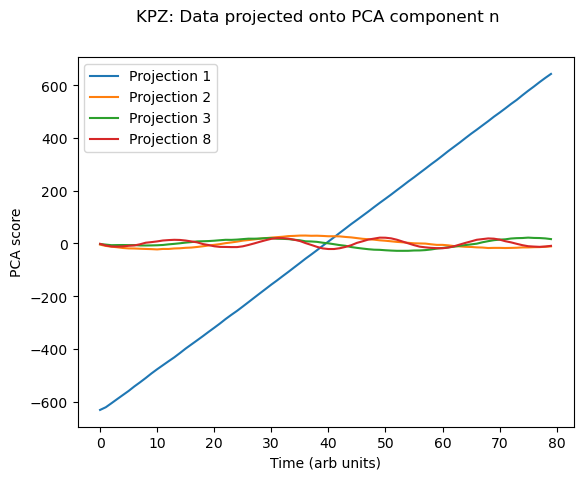

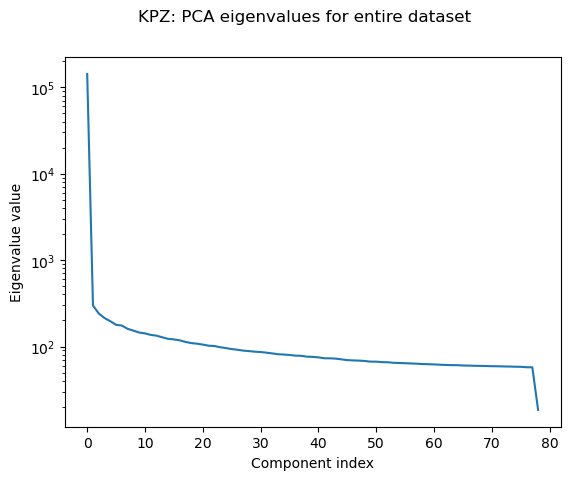

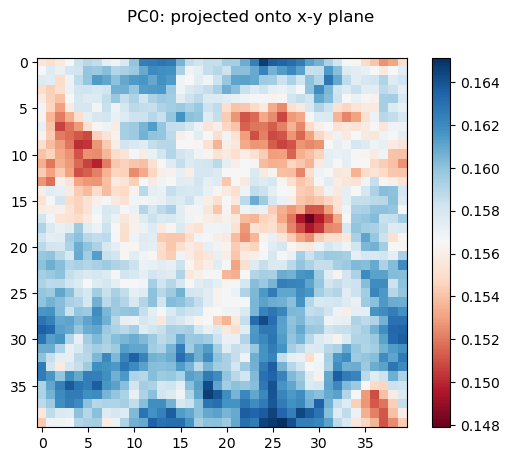

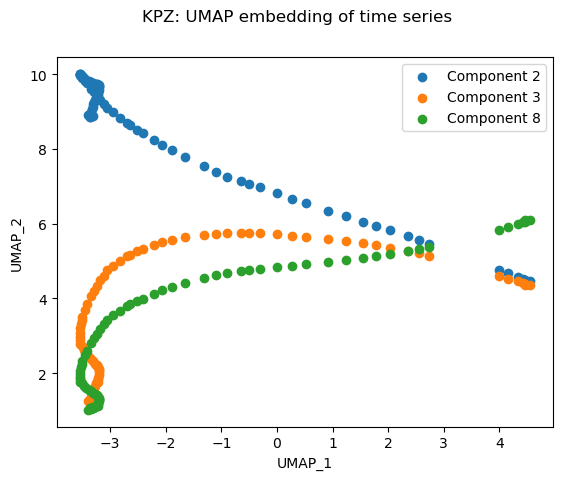

In [72]:
embedding = apply_umap(sreshaped,min_dist=0.1,n_components=50)

scores, comps, eigs = apply_PCA(sreshaped)

comps_reshaped = reshape_components(comps,N)

fig3, axs3 = plt.subplots()
fig3.suptitle("KPZ: Data projected onto PCA component n")
axs3.plot(scores[:,0],label="Projection 1")
axs3.plot(scores[:,1],label="Projection 2")
axs3.plot(scores[:,2],label="Projection 3")
axs3.plot(scores[:,7],label="Projection 8")
axs3.legend()
axs3.set_xlabel("Time (arb units)")
axs3.set_ylabel("PCA score")

fig5, axs5 = plt.subplots()
axs5.plot(eigs[:-1])
axs5.set_yscale('log')
fig5.suptitle("KPZ: PCA eigenvalues for entire dataset")
axs5.set_xlabel("Component index")
axs5.set_ylabel("Eigenvalue value")

fig6, axs6 = plt.subplots()
proj_xy = np.sum(comps_reshaped[0], axis=2)
show = axs6.imshow(proj_xy, cmap='RdBu')
fig6.colorbar(show)
fig6.suptitle("PC0: projected onto x-y plane")

fig4, axs4 = plt.subplots()
axs4.scatter(embedding[:,0],embedding[:,1],label="Component 2")
axs4.scatter(embedding[:,0],embedding[:,2],label="Component 3")
axs4.scatter(embedding[:,0],embedding[:,7],label="Component 8")
axs4.legend()
fig4.suptitle("KPZ: UMAP embedding of time series")
axs4.set_xlabel("UMAP_1")
axs4.set_ylabel("UMAP_2")


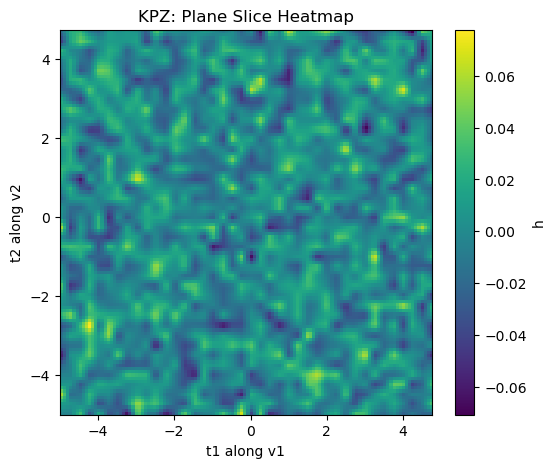

In [ ]:
#Animation of the 

anim = animate_2d_heatmap(planes_list, t1_vals, t2_vals, title="KPZ: Plane Slice Heatmap")
HTML(anim.to_jshtml())